In [ ]:
library(coloc)
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(cowplot)
library(patchwork)

In [2]:
## Set location of nominal fastQTL result files
eqtl_path <- '../data/brain_eqtl/'

ex <- paste0(eqtl_path,'Excitatory.neurons.')
inh <- paste0(eqtl_path,'Inhibitory.neurons.')
oli <- paste0(eqtl_path,'Oligodendrocytes.')
opc <- paste0(eqtl_path,'OPCs...COPs.')
micro <- paste0(eqtl_path,'Microglia.')
astro <- paste0(eqtl_path,'Astrocytes.')
endo <- paste0(eqtl_path,'Endothelial.cells.')
peri <- paste0(eqtl_path,'Pericytes.')

In [3]:
snp_pos = fread('../data/brain_eqtl/snp_pos.txt.gz', sep='\t')

# Process GWAS

In [9]:
selected_trait = 'ad'

In [ ]:
if(selected_trait=='ad'){
sumstats <- vroom::vroom('../brain_coloc/gwas/ad/GCST90012877_buildGRCh37.tsv') %>% 
  mutate(chr=paste0('chr',chromosome)) %>% 
  dplyr::rename(bp_b37=base_pair_location) %>% 
  dplyr::select(variant_id,p_value,chr,bp_b37,effect_allele,other_allele,beta,se=standard_error) %>% 
  filter(!is.na(p_value))

  if(file.exists('../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt')) {
    loci <- fread('../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt', sep='\t')
  }
}

In [5]:
head(sumstats)

variant_id,p_value,chr,bp_b37,effect_allele,other_allele,beta,se
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
rs61769339,0.5322665,chr1,662622,A,G,0.012680341,0.02030317
rs190214723,0.8704074,chr1,693625,T,C,-0.006036290,0.03700045
rs12238997,0.8345078,chr1,693731,A,G,0.003902555,0.01867933
rs72631875,0.1492660,chr1,705882,A,G,-0.039365380,0.02729671
rs181440659,0.2091725,chr1,718505,A,G,-0.064141626,0.05107452
rs116587930,0.7593414,chr1,727841,A,G,-0.008705275,0.02841650


In [6]:
if(!file.exists('../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt')){
  #Supplementary table file from Schwartzentruber et al.
  top_snps <- readxl::read_xlsx('../brain_coloc/gwas/ad/41588_2020_776_MOESM3_ESM.xlsx',sheet=2) %>% 
    dplyr::select(Chr,SNP,`Lead SNP pos`) %>% dplyr::rename(pos=`Lead SNP pos`) %>% 
    mutate(bp_37=paste0('chr',Chr,':',pos)) %>% dplyr::select(-Chr) %>% 
    mutate(SNP=gsub('_.+','',SNP))

  #Add novel loci only observed in replication 
  #+ discovery (not used for their downstream analysis)
  additional_snps <- readxl::read_xlsx('../brain_coloc/gwas/ad/41588_2020_776_MOESM3_ESM.xlsx',sheet=4,skip=43) %>%
    dplyr::select(1,2,3) %>% 
    setNames(c('chr','pos','SNP')) %>% 
    filter(!is.na(SNP)) %>% 
    mutate(bp_37=paste0('chr',chr,':',pos)) %>% 
    dplyr::select(SNP,pos,bp_37)

  top_snps <- rbind(top_snps,additional_snps)
}

In [ ]:
## Get 1KG LD for the top GWAS SNPs at each loci
if(!file.exists('../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt')){
proxy_snps <- lapply(top_snps$SNP,LDlinkR::LDproxy,pop = "EUR", r2d = "r2", 
                     token = '72edb9cc22c9', file = FALSE)
saveRDS(proxy_snps,'../brain_coloc/gwas/ad/loci_LDlinkR.allSNPs.EUR.rds')
}

In [18]:
## Define each locus as the most extreme coordinates of SNPs in LD (r2>=0.1) with the index GWAS SNP.
if(!file.exists('../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt')){
  loci <- lapply(proxy_snps,function(x){
    if(nrow(x)>1){
      x <- filter(x,R2>=0.1) 
      chr <- x$Coord %>% gsub(':.+','',.) %>% unique()
      pos <- x$Coord %>% gsub('chr[0-9]{1,2}:','',.) %>% as.numeric()
      locus_name <- paste0(chr,':',min(pos),'_',max(pos))
      top_snp_df <- filter(x,Distance==0) 
      top_snp <- top_snp_df %>% pull(RS_Number)
      top_snp_pos <- top_snp_df %>% pull(Coord)
      locus <- tibble(GWAS_snp=top_snp,
                    GWAS_snp_pos=top_snp_pos,
                    locus_name=locus_name,
                    chrom=chr,
                    start=min(pos),
                    end=max(pos))
      return(locus)
   }
    else{
      return(NULL)
    }
  }) %>% 
    bind_rows() %>% 
  write_tsv(.,'../brain_coloc/gwas/ad/loci_LDlinkR.r2.0.1.EUR.txt')
}


In [31]:
if(!file.exists('../brain_coloc/gwas/ad/closest.protein.coding.bed')){
  sumstats_min <- sumstats %>% dplyr::select(chr,variant_id,bp_b37,beta)

  gwas_snp <- tibble(GWAS_SNP_pos=unique(loci$GWAS_snp_pos)) %>% 
    separate(GWAS_SNP_pos,into=c('chr','bp_b37'),sep=':') %>% 
    mutate(end=bp_b37) %>% 
    mutate(bp_b37=as.numeric(bp_b37)) %>% 
    left_join(.,sumstats_min,by=c('chr','bp_b37')) %>% 
    arrange(chr,bp_b37) %>% 
    write_tsv(.,'../brain_coloc/gwas/ad/ad_GWAS_index_snps.v2.bed',col_names = FALSE)
}

In [36]:
if(!file.exists('../brain_coloc/gwas/ad/closest.protein.coding.bed')){
  gtf_b37 <- rtracklayer::import('../brain_coloc/gencode/gencode.v39lift37.annotation.gtf.gz') %>% 
    as.data.frame() %>% 
    as_tibble()
}

In [40]:
if(!file.exists('../brain_coloc/gencode/gencode.v39lift37.annotation.protein_coding.1_22.bed')){
  protein_coding <- filter(gtf_b37,type=='gene',gene_type=='protein_coding') %>% 
    mutate(gene_label=paste0(gene_name,'_',gsub('\\..+','',gene_id))) %>% 
    dplyr::select(seqnames,start,end,gene_label) %>% 
    filter(seqnames %in% paste0('chr',1:22)) %>% 
    mutate(seqnames=as.character(seqnames)) %>% 
    arrange(seqnames,start) %>% 
    write_tsv('../brain_coloc/gencode/gencode.v39lift37.annotation.protein_coding.1_22.bed',col_names = FALSE)
}

In [69]:
closest <- fread(paste0('../brain_coloc/gwas/',selected_trait,'/closest.protein.coding.bed'),sep='\t', header=FALSE) %>% 
  setNames(c('chr_snp','start_snp','end_snp','GWAS_snp','beta','chr_gene','start_gene','end_gene','gene','distance')) %>% 
  mutate(GWAS_snp_pos=paste0(chr_snp,':',start_snp)) %>% 
  dplyr::select(GWAS_snp,GWAS_snp_pos,gene,beta,distance) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_') %>% 
  add_count(GWAS_snp) %>% 
  group_by(GWAS_snp) %>% 
  mutate(locus_name_gene=ifelse(n==1,symbol,paste0(symbol,collapse=' - '))) %>% 
  ungroup() %>% 
  dplyr::select(GWAS_snp_pos,locus_name_gene,beta_top_GWAS=beta) %>% 
  unique() %>% arrange(-abs(beta_top_GWAS))
loci <- left_join(loci,closest,by='GWAS_snp_pos')

# Run coloc

In [5]:
# eqtl_ex <- prepare_eqtl(micro,chrom_locus,sumstats_locus)
fun <- function(x){strsplit(x, '_')[[1]][2]}
prepare_eqtl_ibsep <- function(eqtl_path,ibsep_name,chrom_locus,sumstats_locus){
  # original eqtl
  file <- paste0(eqtl_path,gsub('chr','',chrom_locus),'.gz')
  eqtl <- data.table::fread(file,header = FALSE,data.table=FALSE,nThread = 1) %>% 
    dplyr::select(gene=V1,SNP=V2,p_eqtl=V4,beta_eqtl=V5) %>%
    inner_join(.,snp_pos,by='SNP') %>%
    filter(SNP_id_hg19%in%sumstats_locus$SNP_id_hg19) %>%
    mutate(gene_id=sapply(gene, fun)) %>%
    mutate(se_eqtl=abs(beta_eqtl/qnorm(p_eqtl/2)))
    
  # ibsep
  file <- sprintf('../data/brain_data/merged_sumstats/by_chrom_gene/%s/%s.csv', chrom_locus, ibsep_name)
  
  ibsep <- data.table::fread(file, header=TRUE, nThread=1) %>%
    dplyr::select(SNP=SNP_SC, A1, A2, gene_id=GENEID_SC, BETA_BLUE, SE_BLUE, PVAL_BLUE)

  # merge eqtl and ibsep
  merged <- inner_join(eqtl,ibsep,by=c('gene_id', 'SNP'))
  merged <- merged %>%
    mutate(BETA_BLUE=case_when(
        (A2==effect_allele) ~ BETA_BLUE,
        (A1==effect_allele) ~ -BETA_BLUE
        ))
  merged <- merged[(is.na(merged$BETA_BLUE)==FALSE)&(is.na(merged$SE_BLUE)==FALSE),]
  merged <- merged %>%
    add_count(gene) %>% 
    filter(n>10)
    
  return(merged)
}

In [6]:
#  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
run_coloc <- function(tissue_sumstats,tissue_name,sumstats_locus){
  
  if(nrow(tissue_sumstats)==0){
    return (NULL)
  }
  
  out <- lapply(unique(tissue_sumstats$gene),function(x){
    message(x)
    tissue_sumstats_gene <- filter(tissue_sumstats,gene==x)
    sumstats_locus_gene <- sumstats_locus %>% inner_join(.,tissue_sumstats_gene,by='SNP_id_hg19')
    
    if (nrow(sumstats_locus_gene)>0){

       coloc_res_pval <- coloc.abf(
       dataset1=list(beta=sumstats_locus_gene$beta,
                     varbeta=sumstats_locus_gene$se^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     type="cc"),
       dataset2=list(beta=sumstats_locus_gene$beta_eqtl,
                     varbeta=sumstats_locus_gene$se_eqtl^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     sdY=1,
                     type="quant"))$summary %>% 
       as.data.frame()
    colnames(coloc_res_pval) <- x
    
    #Get direction of effect for all SNPs at the locus
    sumstats_locus_gene <- sumstats_locus_gene %>% 
      mutate(direction=case_when(
      (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ sign(beta*beta_eqtl),
      (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -sign(beta*beta_eqtl),
    TRUE ~ 0))
   
   #Get Proportion of positive direction
   direction_prop <- sumstats_locus_gene %>% 
     summarise(prop_pos_direction=sum(direction==1)/n()) %>% 
     setNames(x) %>% 
     as.data.frame()
   rownames(direction_prop) <- 'prop_pos_direction'
   
   direction_sign <- sumstats_locus_gene %>% 
     #Take SNP with strongest evidence of an effect on gene expression
     filter(p_eqtl==min(p_eqtl)) %>% 
     slice_min(n=1,p_value,with_ties=FALSE) %>% 
     summarise(direction=direction,
               beta_gwas=case_when(
                    (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ beta,
                    (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -beta
                    ),
              beta_eqtl=beta_eqtl,
               beta_smr=case_when(
                    direction== 1  ~ abs(beta)/abs(beta_eqtl),
                    direction== -1  ~ -(abs(beta)/abs(beta_eqtl))
                 ),
               ) %>% 
     t() %>% 
     as.data.frame()
   colnames(direction_sign) <- x
   
    #Add direction of effect to coloc results
    coloc_res_pval <- rbind(coloc_res_pval,direction_sign,direction_prop)

    return(coloc_res_pval)
    }
    else{
      return (NULL)
    }
    
})
  
  out_pvalue <- out %>% 
    bind_cols() %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('gene') %>% 
    as_tibble() %>% 
    arrange(-PP.H4.abf) %>% 
    mutate(tissue=tissue_name)
  
  return(out_pvalue)
}

#  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
run_coloc_ibsep <- function(tissue_sumstats,tissue_name,sumstats_locus){
  
  if(nrow(tissue_sumstats)==0){
    return (NULL)
  }
  
  out <- lapply(unique(tissue_sumstats$gene),function(x){
    message(x)
    tissue_sumstats_gene <- filter(tissue_sumstats,gene==x)
    sumstats_locus_gene <- sumstats_locus %>% inner_join(.,tissue_sumstats_gene,by='SNP_id_hg19')
    
    if (nrow(sumstats_locus_gene)>0){

       coloc_res_pval <- coloc.abf(
       dataset1=list(beta=sumstats_locus_gene$beta,
                     varbeta=sumstats_locus_gene$se^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     type="cc"),
       dataset2=list(beta=sumstats_locus_gene$BETA_BLUE,
                     varbeta=sumstats_locus_gene$SE_BLUE^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     sdY=1,
                     type="quant"))$summary %>% 
       as.data.frame()
    colnames(coloc_res_pval) <- x
    
    #Get direction of effect for all SNPs at the locus
    sumstats_locus_gene <- sumstats_locus_gene %>% 
      mutate(direction=case_when(
      (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ sign(beta*BETA_BLUE),
      (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -sign(beta*BETA_BLUE),
    TRUE ~ 0))
   
   #Get Proportion of positive direction
   direction_prop <- sumstats_locus_gene %>% 
     summarise(prop_pos_direction=sum(direction==1)/n()) %>% 
     setNames(x) %>% 
     as.data.frame()
   rownames(direction_prop) <- 'prop_pos_direction'
   
   direction_sign <- sumstats_locus_gene %>% 
     #Take SNP with strongest evidence of an effect on gene expression
     filter(PVAL_BLUE==min(PVAL_BLUE)) %>% 
     slice_min(n=1,p_value,with_ties=FALSE) %>% 
     summarise(direction=direction,
               beta_gwas=case_when(
                    (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ beta,
                    (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -beta
                    ),
              beta_blue=BETA_BLUE,
               beta_smr=case_when(
                    direction== 1  ~ abs(beta)/abs(BETA_BLUE),
                    direction== -1  ~ -(abs(beta)/abs(BETA_BLUE))
                 ),
               ) %>% 
     t() %>% 
     as.data.frame()
   colnames(direction_sign) <- x
   
    #Add direction of effect to coloc results
    coloc_res_pval <- rbind(coloc_res_pval,direction_sign,direction_prop)

    return(coloc_res_pval)
    }
    else{
      return (NULL)
    }
    
})
  
  out_pvalue <- out %>% 
    bind_cols() %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('gene') %>% 
    as_tibble() %>% 
    arrange(-PP.H4.abf) %>% 
    mutate(tissue=tissue_name)
  
  return(out_pvalue)
}

In [ ]:
## ibsep
t0 = Sys.time()
coloc_ibsep_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- filter(sumstats,chr==chrom_locus) %>% 
    filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_ex <- prepare_eqtl_ibsep(ex,'allgenes_Excitatory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_inh <- prepare_eqtl_ibsep(inh,'allgenes_Inhibitory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_oli <- prepare_eqtl_ibsep(oli,'allgenes_Oligodendrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_opc <- prepare_eqtl_ibsep(opc,'allgenes_OPCs_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_micro <- prepare_eqtl_ibsep(micro,'allgenes_Microglia_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_astro <- prepare_eqtl_ibsep(astro,'allgenes_Astrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_endo <- prepare_eqtl_ibsep(endo,'allgenes_Endothelial_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_peri <- prepare_eqtl_ibsep(peri,'allgenes_Pericytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  ex_coloc <- run_coloc_ibsep(eqtl_ex,'Excitatory neurons',sumstats_locus)
  inh_coloc <- run_coloc_ibsep(eqtl_inh,'Inhibitory neurons',sumstats_locus)
  oli_coloc <- run_coloc_ibsep(eqtl_oli,'Oligodendrocytes',sumstats_locus)
  opc_coloc <- run_coloc_ibsep(eqtl_opc,'OPCs / COPs',sumstats_locus)
  micro_coloc <- run_coloc_ibsep(eqtl_micro,'Microglia',sumstats_locus)
  astro_coloc <- run_coloc_ibsep(eqtl_astro,'Astrocytes',sumstats_locus)
  endo_coloc <- run_coloc_ibsep(eqtl_endo,'Endothelial cells',sumstats_locus)
  peri_coloc <- run_coloc_ibsep(eqtl_peri,'Pericytes',sumstats_locus)
  
  pval_eqtl <- rbind(ex_coloc,inh_coloc,oli_coloc,
                     opc_coloc,micro_coloc,astro_coloc,endo_coloc,peri_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }

  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [ ]:
coloc_ibsep_results_all_df <- coloc_ibsep_results_all %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')

In [ ]:
fwrite(coloc_ibsep_results_all_df, sprintf('../data/brain_coloc/result/%s_ibsep.csv', selected_trait), sep='\t')

In [ ]:
## ori eqtl
t0 = Sys.time()
coloc_eqtl_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- filter(sumstats,chr==chrom_locus) %>% 
    filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_ex <- prepare_eqtl_ibsep(ex,'allgenes_Excitatory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_inh <- prepare_eqtl_ibsep(inh,'allgenes_Inhibitory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_oli <- prepare_eqtl_ibsep(oli,'allgenes_Oligodendrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_opc <- prepare_eqtl_ibsep(opc,'allgenes_OPCs_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_micro <- prepare_eqtl_ibsep(micro,'allgenes_Microglia_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_astro <- prepare_eqtl_ibsep(astro,'allgenes_Astrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_endo <- prepare_eqtl_ibsep(endo,'allgenes_Endothelial_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_peri <- prepare_eqtl_ibsep(peri,'allgenes_Pericytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
  inh_coloc <- run_coloc(eqtl_inh,'Inhibitory neurons',sumstats_locus)
  oli_coloc <- run_coloc(eqtl_oli,'Oligodendrocytes',sumstats_locus)
  opc_coloc <- run_coloc(eqtl_opc,'OPCs / COPs',sumstats_locus)
  micro_coloc <- run_coloc(eqtl_micro,'Microglia',sumstats_locus)
  astro_coloc <- run_coloc(eqtl_astro,'Astrocytes',sumstats_locus)
  endo_coloc <- run_coloc(eqtl_endo,'Endothelial cells',sumstats_locus)
  peri_coloc <- run_coloc(eqtl_peri,'Pericytes',sumstats_locus)
  
  pval_eqtl <- rbind(ex_coloc,inh_coloc,oli_coloc,
                     opc_coloc,micro_coloc,astro_coloc,endo_coloc,peri_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [ ]:
coloc_eqtl_results_all_df <- coloc_eqtl_results_all %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')

In [ ]:
fwrite(coloc_eqtl_results_all_df, sprintf('../data/brain_coloc/result/%s_eqtl.csv', selected_trait), sep='\t')

# Plot

## Heatmap

In [4]:
eqtl_res = fread('../data/brain_coloc/result/ad_eqtl.csv', sep='\t')
ibsep_res = fread('../data/brain_coloc/result/ad_ibsep.csv', sep='\t')
print(dim(eqtl_res))
print(dim(ibsep_res))
eqtl_sig <- eqtl_res[eqtl_res$PP.H4.abf > 0.7] %>% mutate(method='Single cell')
ibsep_sig <- ibsep_res[ibsep_res$PP.H4.abf > 0.7] %>% mutate(method='IBSEP')
print(dim(eqtl_sig))
print(dim(ibsep_sig))

[1] 5373   21
[1] 5373   21
[1] 26 22
[1] 44 22


In [5]:
comb_sig <- bind_rows(eqtl_sig, ibsep_sig) 
comb_sig[comb_sig$closest_gene=='ENSG00000269179 - SIGLEC11']$closest_gene = 'SIGLEC11'
comb_sig <- comb_sig %>% arrange(closest_gene, symbol)
comb_sig_min <- comb_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()

print(dim(comb_sig))
print(dim(comb_sig_min))
eqtl_res_wide = eqtl_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
ibsep_res_wide = ibsep_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(eqtl_res_wide))
print(dim(ibsep_res_wide))
eqtl_comb_sig_wide = inner_join(comb_sig_min, eqtl_res_wide, by=c('locus', 'closest_gene', 'symbol'))
ibsep_comb_sig_wide = inner_join(comb_sig_min, ibsep_res_wide, by=c('locus', 'closest_gene', 'symbol'))
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(eqtl_comb_sig_wide)[4:11])), .after='symbol')
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(ibsep_comb_sig_wide)[4:11])), .after='symbol')
print(dim(eqtl_comb_sig_wide))
print(dim(ibsep_comb_sig_wide))

[1] 70 23
[1] 34  3
[1] 1159   11
[1] 1159   11
[1] 33 11
[1] 33 11


In [6]:
mat = matrix(nrow=nrow(eqtl_comb_sig_wide), ncol=8)
fun <- function(x, y){
    if((x>0.7) & (y>0.7)){
        return(1)
    }else if((x>0.7) & (y<=0.7)){
        return(2)
    }else if((x<=0.7) & (y>0.7)){
        return(3)
    }else{
        return(0)
    }
}
mat1 = as.matrix(eqtl_comb_sig_wide[,c(4:11)])
mat2 = as.matrix(ibsep_comb_sig_wide[,c(4:11)])
for(i in 1:nrow(mat)){
    for(j in 1:ncol(mat)){
        mat[i,j] = fun(mat1[i,j], mat2[i,j])
    }
}


In [7]:
sorted_cell_types = c('Excitatory_neurons', 'Inhibitory_neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes')
sorted_cell_names = c('Excitatory neurons', 'Inhibitory neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes')

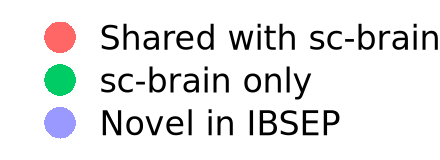

In [28]:
options(repr.plot.width=2.2, repr.plot.height=0.8, repr.plot.res=200)
text_color = '#FFFFFF'
offset = 4
lgd = Legend(labels = c('Shared with sc-brain', 'sc-brain only', 'Novel in IBSEP'), 
             ncol=1, column_gap = unit(6, "mm"), row_gap = unit(1, 'mm'),
             legend_gp = gpar(fill = 'orange'),
             labels_gp = gpar(fontsize=12, fontfamily='ArialMT'), grid_width = unit(8, "mm"),
    graphics = list(
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['1'], col = NA)),
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['2'], col = NA)),
        function(x, y, w, h) grid.circle(x = x, y = y, r = unit(2, "mm"), 
                gp = gpar(fill = colors['3'], col = NA))
    ))
draw(lgd)

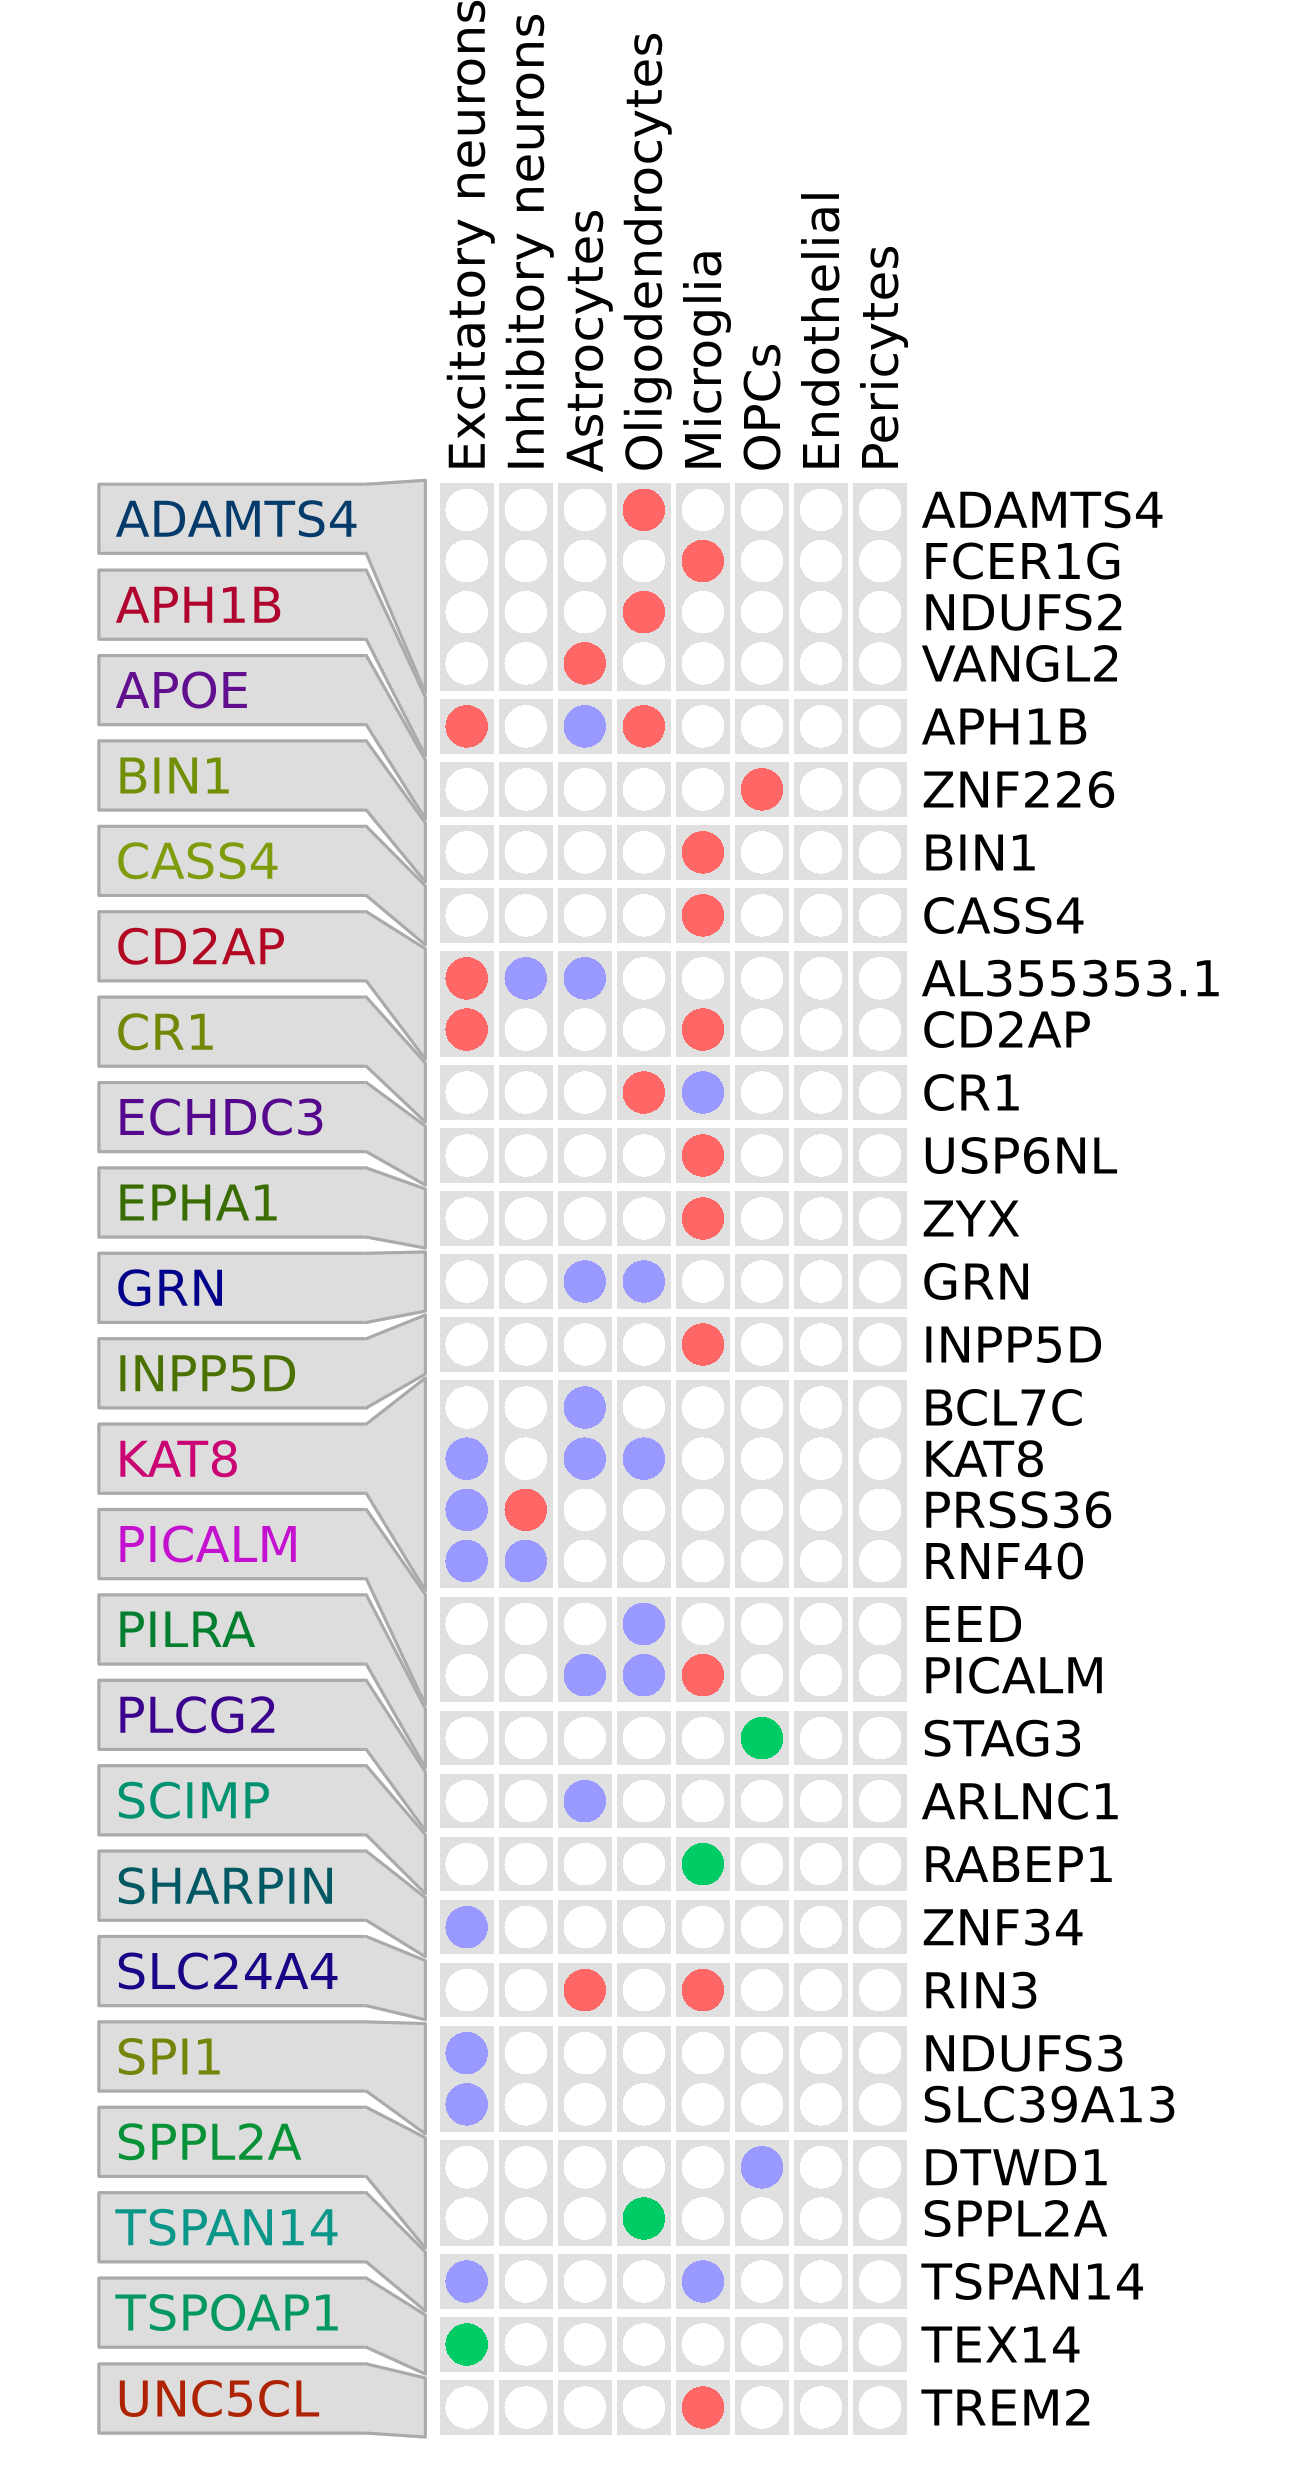

In [14]:
## version2
mat_reorder = mat[,c(3,4,1,6,5,7,2,8)]
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
options(repr.plot.width=4.3, repr.plot.height=8.3, repr.plot.res=300)
col_fun = colorRamp2(c(0, 1, 2, 3), c("grey", "red", "green", "blue"))
colors = structure(c("#FFFFFF", "#FF6666", "#00CC66", "#9999FF"), names = c(0,1,2,3))
# cyto = sapply(eqtl_comb_sig_wide$locus, get_cytoband)
split = eqtl_comb_sig_wide$closest_gene
# split = paste(cyto, split)
text = as.list(unique(split))
names(text) = unique(split)
Heatmap(mat_reorder, col=colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            grid.rect(x = x, y = y, width = unit(4.6, 'mm'), height = unit(4.6, 'mm'),
                     gp = gpar(fill = '#E0E0E0', col = NA))
           grid.circle(x = x, y = y, r = unit(1.8, "mm"), 
                gp = gpar(fill = colors[[mat_reorder[i, j]+1]], col = NA))
           },
        right_annotation=rowAnnotation(labels = anno_text(eqtl_comb_sig_wide$symbol, which='row'), gp = gpar(fontsize = 8)),
        top_annotation=columnAnnotation(labels = anno_text(sorted_cell_names, which='column', just='left', location=unit(0, 'npc')), gp = gpar(fontsize = 10)),
        column_names_side = c("top"),
        row_title_gp = gpar(fontsize = 12),
        row_title_rot = 0,
       width = ncol(mat)*unit(5, "mm"),
       height = nrow(mat)*unit(5, "mm"),
       row_split=split,
        row_title=NULL,
        left_annotation = rowAnnotation(Locus = anno_textbox(split, text, side='left')),
       column_gap = unit(0, "mm"), border = FALSE,
       show_column_names=TRUE, show_heatmap_legend=FALSE,
       heatmap_legend_param = list(title='', 
                                   labels=c('Null', 'Shared', 'Only single cell', 'Only IBSEP'),
                                  grid_height = unit(5, "mm"), grid_width = unit(5, "mm"),
                                   labels_gp = gpar(fontsize = 14))
        )

## Locuszoomr

In [9]:
which(loci$locus_name_gene=='PICALM')

[1] 21

In [11]:
loc_gwas <- locus(data=gwas, xrange=c(85541630, 85900117), seqname=11, ens_db = "EnsDb.Hsapiens.v75")
loc_gwas <- link_LD(loc_gwas, token = "7be0fab0c5d8")

chromosome 11, position 85541630 to 85900117

1505 SNPs/datapoints

Obtaining LD on 1000 SNPs

LDlink server is working...




In [39]:
min(loc_gwas$data$p)

[1] 5.214102e-26

### PICALM-PICALM: Micro

In [12]:
## eqtl
eqtl <- prepare_eqtl_ibsep(micro,'allgenes_Microglia_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
unique(eqtl$gene)
dim(eqtl)
eqtl_min <- eqtl[eqtl$gene=='PICALM_ENSG00000073921',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=p_eqtl) %>%
    dplyr::filter(!is.na(rsid))
dim(eqtl_min)

[1] "PICALM_ENSG00000073921"     "EED_ENSG00000074266"       
[3] "CCDC81_ENSG00000149201"     "AP001528.1_ENSG00000246523"
[5] "TMEM135_ENSG00000166575"

[1] 2902   17

[1] 730   4

In [14]:
loc_gwas_eqtl_index <- locus(data=gwas, xrange=c(85541630, 85900117), seqname=11, index='rs561655', ens_db = "EnsDb.Hsapiens.v75")
loc_gwas_eqtl_index <- link_LD(loc_gwas_eqtl_index, token = "7be0fab0c5d8")
eqtl_merged <- eqtl_min %>%
    inner_join(loc_gwas_eqtl_index$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
eqtl_merged <- eqtl_min %>%
    inner_join(loc_gwas_eqtl_index$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
loc_eqtl <- locus(data=eqtl_merged, xrange=c(85541630, 85900117), seqname=11, ens_db = "EnsDb.Hsapiens.v75", LD='ld')

rs561655, chromosome 11, position 85541630 to 85900117

1505 SNPs/datapoints

Obtaining LD on 1000 SNPs

LDlink server is working...


chromosome 11, position 85541630 to 85900117

729 SNPs/datapoints



In [15]:
## ibsep
ibsep_min <- eqtl[eqtl$gene=='PICALM_ENSG00000073921',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=PVAL_BLUE) %>%
    dplyr::filter(!is.na(rsid))
dim(ibsep_min)

[1] 730   4

In [17]:
ibsep_merged <- ibsep_min %>%
    inner_join(loc_gwas$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)

In [18]:
loc_ibsep <- locus(data=ibsep_merged, xrange=c(85541630, 85900117), seqname=11, ens_db = "EnsDb.Hsapiens.v75", LD='ld')

chromosome 11, position 85541630 to 85900117

729 SNPs/datapoints



### PICALM-PICALM: Oligo

In [19]:
## eqtl
eqtl2 <- prepare_eqtl_ibsep(oli,'allgenes_Oligodendrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
unique(eqtl2$gene)
dim(eqtl2)
eqtl_min2 <- eqtl2[eqtl2$gene=='PICALM_ENSG00000073921',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=p_eqtl) %>%
    dplyr::filter(!is.na(rsid))
dim(eqtl_min2)

[1] "DLG2_ENSG00000150672"     "TMEM126B_ENSG00000171204"
[3] "CREBZF_ENSG00000137504"   "SYTL2_ENSG00000137501"   
[5] "PICALM_ENSG00000073921"   "EED_ENSG00000074266"     
[7] "HIKESHI_ENSG00000149196"  "CCDC81_ENSG00000149201"  
[9] "TMEM135_ENSG00000166575"

[1] 6108   17

[1] 730   4

In [25]:
loc_gwas_eqtl_index2 <- locus(data=gwas, xrange=c(85541630, 85900117), seqname=11, index='rs11234552', ens_db = "EnsDb.Hsapiens.v75")
loc_gwas_eqtl_index2 <- link_LD(loc_gwas_eqtl_index2, token = "7be0fab0c5d8")
eqtl_merged2 <- eqtl_min2 %>%
    inner_join(loc_gwas_eqtl_index2$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)

rs11234564, chromosome 11, position 85541630 to 85900117

1505 SNPs/datapoints

Obtaining LD on 1000 SNPs

LDlink server is working...




In [26]:
loc_eqtl2 <- locus(data=eqtl_merged2, xrange=c(85541630, 85900117), seqname=11, ens_db = "EnsDb.Hsapiens.v75", LD='ld')

chromosome 11, position 85541630 to 85900117

729 SNPs/datapoints



In [27]:
## ibsep
ibsep_min2 <- eqtl2[eqtl2$gene=='PICALM_ENSG00000073921',] %>%
    separate(SNP_id_hg19, into=c('CHR', 'POS'), sep=':') %>%
    dplyr::mutate(CHR=as.integer(gsub('chr', '', CHR)), POS=as.integer(POS)) %>%
    dplyr::select(chrom=CHR, pos=POS, rsid=SNP, p=PVAL_BLUE) %>%
    dplyr::filter(!is.na(rsid))
dim(ibsep_min2)
ibsep_min2[which.min(ibsep_min2$p),]

[1] 730   4

,chrom,pos,rsid,p
,<int>,<int>,<chr>,<dbl>
694,11,85869944,rs11234564,2.456758e-13


In [28]:
loc_gwas_ibsep_index2 <- locus(data=gwas, xrange=c(85541630, 85900117), seqname=11, index='rs11234564', ens_db = "EnsDb.Hsapiens.v75")
loc_gwas_ibsep_index2 <- link_LD(loc_gwas_ibsep_index2, token = "7be0fab0c5d8")
ibsep_merged2 <- ibsep_min2 %>%
    inner_join(loc_gwas_ibsep_index2$data, by='rsid') %>%
    dplyr::select(chrom=chrom.x, pos=pos.x, rsid, p=p.x, ld)
loc_ibsep2 <- locus(data=ibsep_merged2, xrange=c(85541630, 85900117), seqname=11, ens_db = "EnsDb.Hsapiens.v75", LD='ld')

rs11234564, chromosome 11, position 85541630 to 85900117

1505 SNPs/datapoints

Obtaining LD on 1000 SNPs
chromosome 11, position 85541630 to 85900117

729 SNPs/datapoints



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


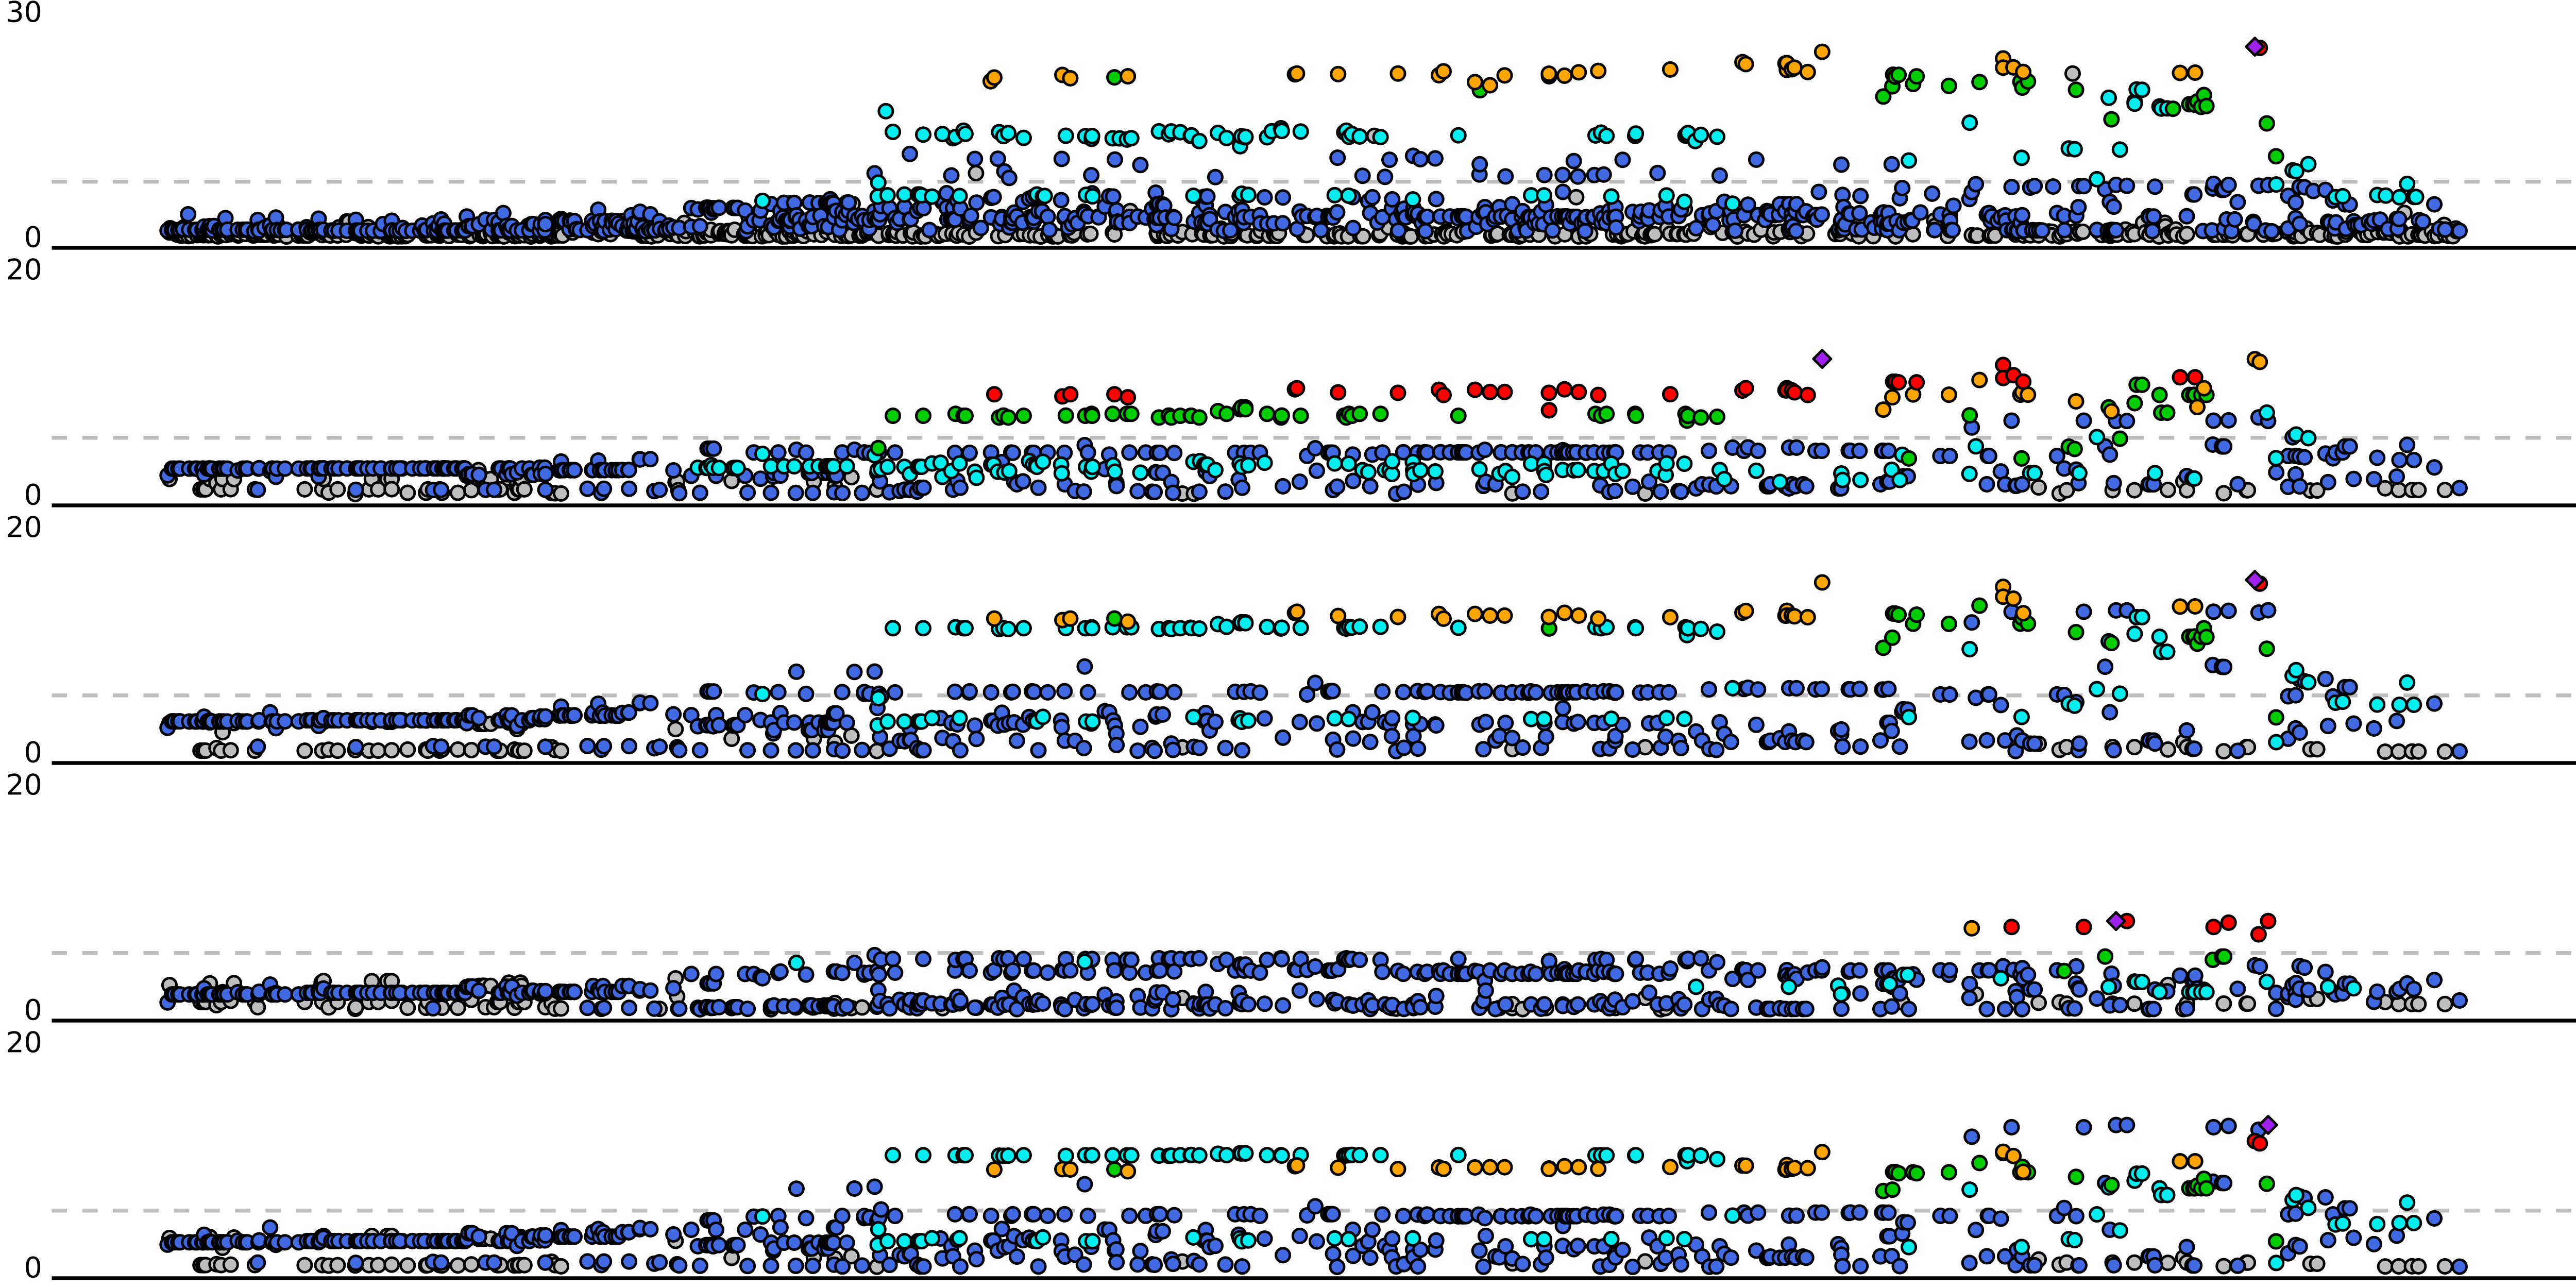

In [67]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=500)
ymax = 30
ymax2 = 20
axis_size = 8
b = 0
l = 0
t = 0
r = 0.1
# element_text(size=axis_size, margin = margin(0,0,0,0)
p1 = gg_scatter(loc_gwas, xticks = FALSE, legend_pos=NULL, size=1.5, pcutoff=5e-8) + labs(x=NULL, y=NULL) + 
    scale_y_continuous(breaks = c(0, ymax), limits=c(0,ymax)) + 
    theme(axis.line.y=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_text(size=axis_size, margin = margin(0,0,0,0)),
         plot.margin = unit(c(b,l,t,r), "cm"))
p2 = gg_scatter(loc_eqtl, xticks = FALSE, legend_pos=NULL, size=1.5, pcutoff=1e-5) + labs(x=NULL, y=NULL) +
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) +
    theme(axis.line.y=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_text(size=axis_size, margin = margin(0,0,0,0)),
         plot.margin = unit(c(b,l,t,r), "cm"))
p3 = gg_scatter(loc_ibsep, xticks = FALSE, legend_pos=NULL, size=1.5, pcutoff=1e-5) + labs(x=NULL, y=NULL) +
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) +
    theme(axis.line.y=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_text(size=axis_size, margin = margin(0,0,0,0)),
         plot.margin = unit(c(b,l,t,r), "cm"))
p4 = gg_scatter(loc_eqtl2, xticks = FALSE, legend_pos=NULL, size=1.5, pcutoff=1e-5) + labs(x=NULL, y=NULL) +
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) +
    theme(axis.line.y=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_text(size=axis_size, margin = margin(0,0,0,0)),
         plot.margin = unit(c(b,l,t,r), "cm"))
p5 = gg_scatter(loc_ibsep2, xticks = FALSE, legend_pos=NULL, size=1.5, pcutoff=1e-5) + labs(x=NULL, y=NULL) +
    scale_y_continuous(breaks = c(0, ymax2), limits=c(0,ymax2)) +
    theme(axis.line.y=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_text(size=axis_size, margin = margin(0,0,0,0)),
         plot.margin = unit(c(b,l,t,r), "cm"))
plot_grid(plotlist=list(p1,p2,p3,p4,p5), ncol=1, align='v')

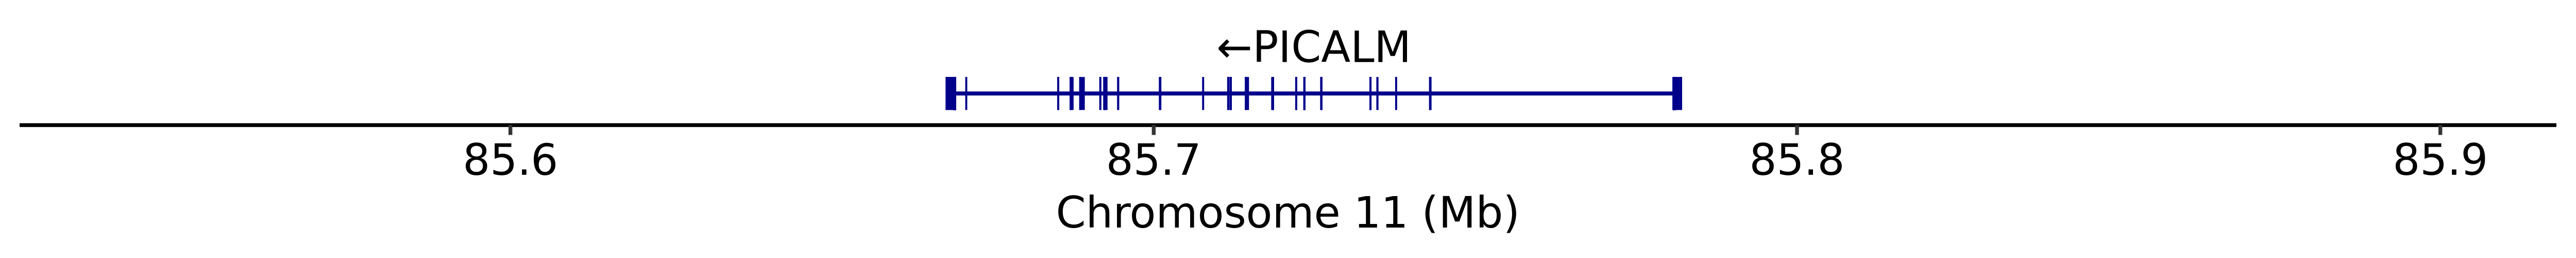

In [88]:
options(repr.plot.width=10, repr.plot.height=1, repr.plot.res=500)
g <- gg_genetracks(loc_gwas, maxrows=1, filter_gene_name='PICALM', cex.text=1.) + 
    theme(axis.text.x=element_text(size=12), axis.title.x=element_text(size=12))
g